# Kaggle House Price Challenge (Ames, Iowa) : 
<p><a name="sections"></a></p>

## Sections

- <a href="#trees">Decision Trees</a><br>
 - <a href="#trees_plot">Plots: Sweep Hyperparameter</a><br>
 - <a href="#trees_cvgrid">CV Grid Search</a><br>
 - <a href="#trees_plot">Plot: Variable Importance</a><br>
- <a href="#forest">Random Forests</a><br>
 - <a href="#forest_plot">Plots: Sweep Hyperparameter</a><br>
 - <a href="#forest_cvgrid">CV Grid Search</a><br>
- <a href="#gboost">Gradient Boosting</a><br>
 - <a href="#gboost_plot">Plots: Sweep Hyperparameter</a><br>
 - <a href="#gboost_cvgrid">CV Grid Search</a><br>
- <a href="#kaggle">Kaggle Submissions</a><br>
 - <a href="#kaggle_trees">Best Predictions : Decision Trees</a><br>
 - <a href="#kaggle_forest">Best Predictions : Random Forests</a><br>
 - <a href="#kaggle_gboost">Best Predictions : Gradient Boosting</a><br>
 - <a href="#kaggle_result">Kaggle Results : Root-Mean-Square-Log-Error</a><br>

In [284]:
import pandas as pd
import numpy as np
import math

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn import tree
from scipy.stats import skew

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

In [40]:
pd.set_option('display.max_columns', 100)

train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

In [41]:
# Save the 'Id' column
train_ID = train_df['Id']
test_ID = test_df['Id']

# Now drop the 'Id' colum since we can not use it as a feature to train our model.
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

In [42]:
def is_outlier(points, thresh = 3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [43]:
Y_TRAIN= train_df['SalePrice']
X_TRAIN = train_df.drop('SalePrice', axis=1)
X_TEST = test_df.copy()

In [44]:
#del train_df, test_df
print(X_TRAIN.shape)
print(X_TEST.shape)

(1460, 79)
(1459, 79)


In [45]:
Y_TRAIN=np.log(Y_TRAIN)
#print(Y_TRAIN)

In [46]:
all_data = pd.concat([X_TRAIN, X_TEST])
all_data.shape

(2919, 79)

#### Find all Categorical Data

In [47]:
cats = []
for col in all_data.columns.values:
    if all_data[col].dtype == 'object':
        cats.append(col)

#### Create Separate Continuous Data

In [48]:
df_cont = all_data.drop(cats, axis=1)
df_cat = all_data[cats]

### Handle Missing Data for continuous data
- If any column contains more than 50 entries of missing data, drop the column
- If any column contains fewer that 50 entries of missing data, replace those missing values with the median for that column
- Remove outliers using Median Absolute Deviation
- Calculate skewness for each variable and if greater than 0.75 transform it
- Apply the sklearn.Normalizer to each column

In [49]:
for col in df_cont.columns.values:
    if np.sum(df_cont[col].isnull()) > 50:
        df_cont = df_cont.drop(col, axis = 1)
    elif np.sum(df_cont[col].isnull()) > 0:
        median = df_cont[col].median()
        idx = np.where(df_cont[col].isnull())[0]
        df_cont[col].iloc[idx] = median

        outliers = np.where(is_outlier(df_cont[col]))
        df_cont[col].iloc[outliers] = median
        
        if skew(df_cont[col]) > 0.75:
            df_cont[col] = np.log(df_cont[col])
            df_cont[col] = df_cont[col].apply(lambda x: 0 if x == -np.inf else x)
        
        df_cont[col] = Normalizer().fit_transform(df_cont[col].reshape(1,-1))[0]

C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: reshape is deprecated and will raise in a subs


#### Handle Missing Data for Categorical Data

- If any column contains more than 50 entries of missing data, drop the column
- If any column contains fewer that 50 entries of missing data, replace those values with the 'MIA'
- Apply the sklearn.LabelEncoder
- For each categorical variable determine the number of unique values and for each, create a new column that is binary



In [50]:
for col in df_cat.columns.values:
    if np.sum(df_cat[col].isnull()) > 50:
        df_cat = df_cat.drop(col, axis = 1)
        continue
    elif np.sum(df_cat[col].isnull()) > 0:
        df_cat[col] = df_cat[col].fillna('MIA')
        
    df_cat[col] = LabelEncoder().fit_transform(df_cat[col])
    
    num_cols = df_cat[col].max()
    for i in range(num_cols):
        col_name = col + '_' + str(i)
        df_cat[col_name] = df_cat[col].apply(lambda x: 1 if x == i else 0)
        
    df_cat = df_cat.drop(col, axis = 1)

C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [51]:
df_cont.shape

(2919, 34)

In [52]:
df_cat.shape


(2919, 171)

In [53]:
all_data=pd.concat([df_cont, df_cat], axis = 1)
X_TRAIN = all_data.iloc[0:1460,]
X_TEST = all_data.iloc[1460:,]

In [54]:
print(X_TRAIN.shape)
print(Y_TRAIN.shape)
print(X_TEST.shape)

(1460, 205)
(1460,)
(1459, 205)


### Create Test/Train Split

In [55]:
x_train, x_test, y_train, y_test = train_test_split(X_TRAIN, Y_TRAIN, test_size = .25, random_state=5)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1095, 205)
(1095,)
(365, 205)
(365,)


In [335]:
tree_model = tree.DecisionTreeRegressor(min_samples_leaf=10,max_depth=9)
tree_model.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [60]:
#tree_model.feature_importances_

In [96]:
calc_rmsle(tree_model,x_test,y_test)

0.19100427008847184

<p><a name="trees"></a></p>
## Decision Trees

In [98]:
def calc_rmsle (tree_model, x_input, y_input):
    msle=np.mean(( y_input-tree_model.predict(x_input))** 2)
    return(math.sqrt(msle))

### Depth of Tree

In [180]:
depth = range(1, 18)
depth_train_error = []
depth_test_error = []
tree_model = tree.DecisionTreeRegressor()
for i in depth:
    tree_model.set_params(max_depth=i, min_samples_leaf=1)
    tree_model.fit(x_train, y_train)
    depth_train_error.append(calc_rmsle(tree_model,x_train,y_train))
    depth_test_error.append(calc_rmsle(tree_model,x_test,y_test))

### Minimum Number of Samples per Leaf

In [182]:
leaf = range(1, 30)
leaf_train_error = []
leaf_test_error = []
tree_model = tree.DecisionTreeRegressor()
for i in leaf:
    tree_model.set_params( min_samples_leaf=i)
    tree_model.fit(x_train, y_train)
    leaf_train_error.append(calc_rmsle(tree_model,x_train,y_train))
    leaf_test_error.append(calc_rmsle(tree_model,x_test,y_test))

<p><a name="trees_plot"></a></p>
### Plots : Sweep Tree Depth & Minimum Sample per Leaf 

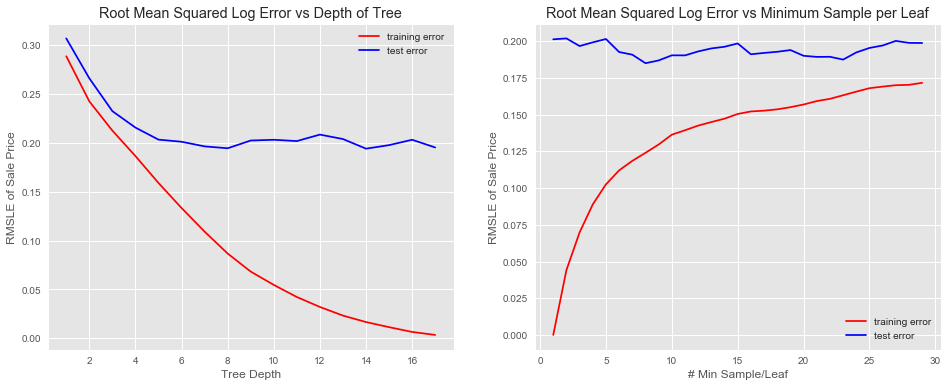

In [193]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
#plt.figure(figsize=(9, 6))
plt.subplot(1, 2, 1)
#plt.fig
plt.plot(depth, depth_train_error, c='red', label='training error')
plt.plot(depth, depth_test_error, c='blue', label='test error')
plt.legend()
plt.ylabel('RMSLE of Sale Price')
plt.xlabel('Tree Depth')
plt.title('Root Mean Squared Log Error vs Depth of Tree')

plt.subplot(1, 2, 2)
plt.plot(min_leaf, leaf_train_error, c='red', label='training error')
plt.plot(min_leaf, leaf_test_error, c='blue', label='test error')
plt.legend()
plt.ylabel('RMSLE of Sale Price')
plt.xlabel('# Min Sample/Leaf')
plt.title('Root Mean Squared Log Error vs Minimum Sample per Leaf')
plt.show()

<p><a name="trees_cvgrid"></a></p>
### CV Grid Search for Decision Tree

In [261]:
from sklearn.model_selection import GridSearchCV
grid_para_tree = [{
    "criterion": ["mse"],
    "max_depth": range(1, 30),
    "min_samples_leaf": np.linspace(start=2, stop=30, num=15, dtype=int)
}]
tree_model.set_params(random_state=0)
grid_search_tree = GridSearchCV(tree_model, grid_para_tree, cv=5,scoring='neg_mean_squared_error', n_jobs=-1)
%time grid_search_tree.fit(x_train, y_train)

Wall time: 22.9 s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=29, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'criterion': ['mse'], 'min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]), 'max_depth': range(1, 30)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [262]:
## best parameters
print(grid_search_tree.best_params_)
best_tree_model=grid_search_tree
calc_rmsle(best_tree_model,x_test,y_test)

{'criterion': 'mse', 'min_samples_leaf': 10, 'max_depth': 9}


0.19100427008847184

In [263]:
best_tree_model.predict(x_test)
rmsle_best_tree_train=calc_rmsle(best_tree_model,x_train,y_train)
rmsle_best_tree_test=calc_rmsle(best_tree_model,x_test,y_test)
print(rmsle_best_tree_train)
print(rmsle_best_tree_test)

0.1374470662167449
0.19100427008847184


<p><a name="trees_plot2"></a></p>
### Plot: Feature Importance

In [169]:
feature_importance = list(zip(x_train.columns, best_tree_model.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')
#[::-1]
#feature_sort

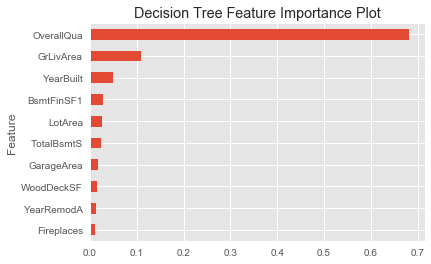

In [258]:
feature_name=[i.decode("utf-8") for (i, j) in feature_sort if j>0.01]
feature_val=[j for (i, j) in feature_sort if j>0.01]
#feature_sort.
fimp_df=pd.DataFrame({'Feature':feature_name,'Importance':feature_val}).reset_index(drop=True)
#fimp_df.plot.barh(x='Feature',y='Importance')
fimp_df.plot(kind='barh',x='Feature',y='Importance',
             legend=None, title='Decision Tree Feature Importance Plot')

In [174]:
pred_df.to_csv('tree.csv',index=None)

<p><a name="forest"></a></p>
## Random Forest

In [255]:
rf_model = RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [256]:
rf_model.fit(x_train, y_train)
msle=np.mean(( y_test-rf.predict(x_test))** 2)
math.sqrt(msle)

0.13542019178263243

In [215]:
rf_model = RandomForestRegressor(min_samples_leaf=10,max_depth=9,n_jobs=-1)
ntrees_range = range(20, 500, 25)  # OOB score will warning if too few trees
ntrees_train_error = []
ntrees_test_error = []
oob_error = []

for ntrees in ntrees_range:
    rf_model.set_params(n_estimators=ntrees, random_state=0,  oob_score=True)
    rf_model.fit(x_train, y_train)
    ntrees_train_error.append(calc_rmsle(rf_model,x_train,y_train))
    ntrees_test_error.append(calc_rmsle(rf_model,x_test,y_test))

<p><a name="forest_plot"></a></p>
### Plot: Sweep Hyperparameter Number of Trees

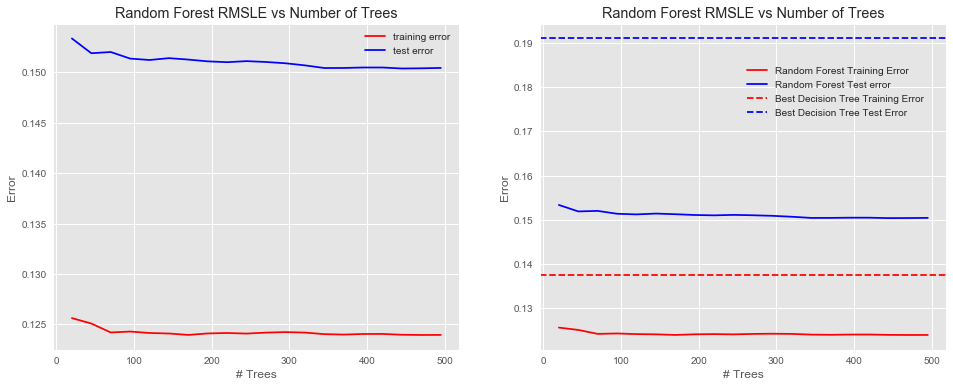

In [243]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(ntrees_range, ntrees_train_error, c='red', label='training error')
plt.plot(ntrees_range, ntrees_test_error, c='blue', label='test error')
plt.ylabel('Error')
plt.xlabel('# Trees')
plt.title('Random Forest RMSLE vs Number of Trees')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ntrees_range, ntrees_train_error, c='red', label='Random Forest Training Error')
plt.plot(ntrees_range, ntrees_test_error, c='blue', label='Random Forest Test error')
plt.axhline(y=rmsle_best_tree_train,ls='--',c='red',label='Best Decision Tree Training Error')
plt.axhline(y=rmsle_best_tree_test,ls='--',c='blue',label='Best Decision Tree Test Error')
rmsle_best_tree_train
plt.ylabel('Error')
plt.xlabel('# Trees')
plt.title('Random Forest RMSLE vs Number of Trees')
plt.legend(handles=[rf_train_line], loc=2)
plt.legend(handles=[rf_test_line], loc=2)
plt.legend(loc=(0.5,0.7))
plt.show()

<p><a name="forest_cvgrid"></a></p>
### CV Grid Search for Random Forest

In [272]:
grid_search_forest = RandomForestRegressor(n_jobs=-1)
grid_para_forest = [{
    "n_estimators": [50, 100,200,500],
    "criterion": ["mse"],
    "min_samples_leaf": np.linspace(start=2, stop=30, num=15, dtype=int)
    }]
grid_search_forest = GridSearchCV(grid_search_forest, grid_para_forest, 
                                  scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
%time grid_search_forest.fit(x_train, y_train)

Wall time: 1min 32s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [50, 100, 200, 500], 'min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]), 'criterion': ['mse']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [273]:
## best parameters
print(grid_search_forest.best_params_)
best_forest_model=grid_search_forest

{'criterion': 'mse', 'n_estimators': 100, 'min_samples_leaf': 2}


In [274]:
best_forest_model.predict(x_test)
rmsle_best_forest_train=calc_rmsle(best_forest_model,x_train,y_train)
rmsle_best_forest_test=calc_rmsle(best_forest_model,x_test,y_test)
print(rmsle_best_forest_train)
print(rmsle_best_forest_test)

0.06853149227853164
0.13721319190402384


<p><a name="gboost"></a></p>
## Gradient Boosting

In [320]:
print(learnrate_range)

[0.0001, 0.00017782794100389227, 0.00031622776601683794, 0.0005623413251903491, 0.001, 0.0017782794100389228, 0.0031622776601683794, 0.005623413251903491, 0.01, 0.017782794100389229, 0.031622776601683791, 0.056234132519034911, 0.10000000000000001, 0.17782794100389229, 0.31622776601683794, 0.56234132519034907]


In [314]:
gboost_model = GradientBoostingRegressor()
learnrate_range = learnrate_range = [10**i for i in np.arange(-4.,0,.25)]
#print(learnrate_range)
gboost_train_error = []
gboost_test_error = []
oob_error = []

for learnrate in learnrate_range:
    gboost_model.set_params(learning_rate=learnrate, random_state=0,n_estimators=100)
    gboost_model.fit(x_train, y_train)
    gboost_train_error.append(calc_rmsle(gboost_model,x_train,y_train))
    gboost_test_error.append(calc_rmsle(gboost_model,x_test,y_test))

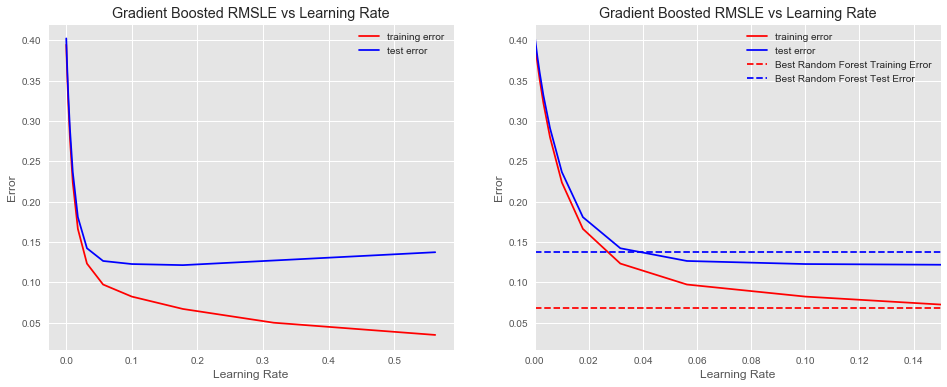

In [318]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(learnrate_range, gboost_train_error, c='red', label='training error')
plt.plot(learnrate_range, gboost_test_error, c='blue', label='test error')
plt.ylabel('Error')
plt.xlabel('Learning Rate')
plt.title('Gradient Boosted RMSLE vs Learning Rate')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(learnrate_range, gboost_train_error, c='red', label='training error')
plt.plot(learnrate_range, gboost_test_error, c='blue', label='test error')
plt.axhline(y=rmsle_best_forest_train,ls='--',c='red',label='Best Random Forest Training Error')
plt.axhline(y=rmsle_best_forest_test,ls='--',c='blue',label='Best Random Forest Test Error')
plt.ylabel('Error')
plt.xlabel('Learning Rate')
plt.title('Gradient Boosted RMSLE vs Learning Rate')
plt.xlim([0,0.15])
plt.legend()

<p><a name="gboost_cvgrid"></a></p>
### CV Grid Search for Gradient Boosting

In [330]:
grid_search_gboost = GradientBoostingRegressor()
grid_para_gboost = [{
    "learning_rate": [0.01,0.05,0.1,0.15,0.2,0.25],
    "n_estimators": [50, 100, 200, 300, 500]
    #"max_depth": range(1, 30),
    #"min_samples_leaf": np.linspace(start=2, stop=30, num=15, dtype=int)
    }]
grid_search_gboost = GridSearchCV(grid_search_gboost, grid_para_gboost, 
                                  scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
%time grid_search_gboost.fit(x_train, y_train)

Wall time: 45.1 s


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25], 'n_estimators': [50, 100, 200, 300, 500]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [331]:
print(grid_search_gboost.best_params_)
best_gboost_model=grid_search_gboost

{'learning_rate': 0.05, 'n_estimators': 500}


In [332]:
best_gboost_model.predict(x_test)
rmsle_best_gboost_train=calc_rmsle(best_gboost_model,x_train,y_train)
rmsle_best_gboost_test=calc_rmsle(best_gboost_model,x_test,y_test)
print(rmsle_best_gboost_train)
print(rmsle_best_gboost_test)

0.05812508902694144
0.11789364092116067


<p><a name="kaggle"></a></p>
## Kaggle Submission

<p><a name="kaggle_trees"></a></p>
### Best Model Decision Tree

In [281]:
trees_pred=np.exp(best_tree_model.predict(X_TEST))
kaggle_trees_df=pd.DataFrame({'Id':test_ID,'SalePrice':trees_pred})
kaggle_trees_df.to_csv('kaggle_trees_df.csv',index=None)
kaggle_trees_df.head()

,Id,SalePrice
0,1461,126653.495820
1,1462,183453.357033
2,1463,168476.140687
3,1464,207746.422842
4,1465,198692.414590


<p><a name="kaggle_forest"></a></p>
### Best Model Random Forest

In [282]:
forest_pred=np.exp(best_forest_model.predict(X_TEST))
kaggle_forest_df=pd.DataFrame({'Id':test_ID,'SalePrice':forest_pred})
kaggle_forest_df.to_csv('kaggle_forest_df.csv',index=None)
kaggle_forest_df.head()

,Id,SalePrice
0,1461,129330.422500
1,1462,159727.943250
2,1463,173488.318530
3,1464,180255.467416
4,1465,197140.822336


<p><a name="kaggle_gboost"></a></p>
### Best Model Gradient Boosting

In [333]:
gboost_pred=np.exp(best_gboost_model.predict(X_TEST))
kaggle_gboost_df=pd.DataFrame({'Id':test_ID,'SalePrice':gboost_pred})
kaggle_gboost_df.to_csv('kaggle_gboost_df.csv',index=None)
kaggle_gboost_df.head()


,Id,SalePrice
0,1461,126637.017226
1,1462,149549.262990
2,1463,188220.646032
3,1464,197097.401713
4,1465,195939.259603


<p><a name="kaggle_result"></a></p>
### Kaggle RMSLE

In [334]:
kaggle_trees_rmsle=0.20357
kaggle_forest_rmsle=0.14885
kaggle_gboost_rmsle=0.13338